In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import glob, os
base="/content/drive/MyDrive/food-10/food-10"
print("Checkpoints found (drive):")
print(glob.glob(base + "/**/best_*.pth", recursive=True))
print("History files:")
print(glob.glob(base + "/**/history*.json", recursive=True))

Mounted at /content/drive
Checkpoints found (drive):
['/content/drive/MyDrive/food-10/food-10/outputs/best_resnet50.pth', '/content/drive/MyDrive/food-10/food-10/outputs_experiments/best_resnet101_resumed.pth', '/content/drive/MyDrive/food-10/food-10/outputs_experiments/best_effnetb0_freeze1.pth', '/content/drive/MyDrive/food-10/food-10/outputs_experiments/best_resnet101_full.pth']
History files:
['/content/drive/MyDrive/food-10/food-10/outputs/history.json', '/content/drive/MyDrive/food-10/food-10/outputs_experiments/history_resnet101_resumed.json']


In [ ]:
#Notebook 05- Experiments & Alternative Models
!pip install -q timm==0.9.2
!pip install -q torchinfo
!pip install -q einops

import os, random, time, json, shutil
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import timm  #for the efficientnet (and optional ViT model, which I haven't used).
print("timm version:",timm.__version__)
print("Torch:",torch.__version__, "CUDA:",torch.cuda.is_available())

timm version: 1.0.22
Torch: 2.9.0+cu126 CUDA: False


In [ ]:
#Cell 2- All the configurations
ROOT="/content/drive/MyDrive/food-10/food-10"
CSV_DIR=os.path.join(ROOT, "prepared_splits")
OUT_DIR="/content/food10_experiments"
DRIVE_OUT_DIR=os.path.join(ROOT,"outputs_experiments")
os.makedirs(OUT_DIR,exist_ok=True)
os.makedirs(DRIVE_OUT_DIR,exist_ok=True)

SEED=42
def set_seed(seed=SEED):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed()
CFG={
    "img_size": 224,
    "batch_size": 32,      #we can reduce it if there is OOM
    "epochs": 12,           #baseline quick; we can increase to 12-20 for final runs
    "lr": 3e-4,
    "weight_decay": 1e-4,
    "num_workers": min(8, os.cpu_count() or 4),
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "save_dir": OUT_DIR,
    "drive_out": DRIVE_OUT_DIR,
    "mixed_precision": True}
print("Device:", CFG['device'], "Out dir:", OUT_DIR)
#Classifier-Free Guidance. It is a method that enhances how closely a generated img. adheres to a given cond. (like a text prompt/class label) w/o needing a separate, explicit classifier model.

Device: cpu Out dir: /content/food10_experiments


In [ ]:
#Cell 3- loading prepared CSVs
train_df=pd.read_csv(os.path.join(CSV_DIR,"train.csv"))
val_df=pd.read_csv(os.path.join(CSV_DIR,"val.csv"))
print("Train rows:",len(train_df),"Val rows:",len(val_df))
print("Columns:",train_df.columns.tolist())
assert 'fullpath' in train_df.columns and 'label' in train_df.columns, "train.csv must include fullpath and label"
classes=sorted(train_df['class'].unique())
num_classes=len(classes)
print("Num classes:", num_classes)

Train rows: 6000 Val rows: 1500
Columns: ['path', 'class', 'fullpath', 'label']
Num classes: 10


In [ ]:
#Cell 4- Transforms & dataset
IMG_SIZE=CFG['img_size']
train_transforms=transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2,0.2,0.2,0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])])

val_transforms=transforms.Compose([
    transforms.Resize(int(IMG_SIZE*1.15)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])])

class Food10Dataset(Dataset):
    def __init__(self,df,transform=None):
        self.df=df.reset_index(drop=True)
        self.transform=transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        r=self.df.iloc[idx]
        img=Image.open(r['fullpath']).convert('RGB')
        if self.transform:
            img=self.transform(img)
        label=int(r['label'])
        return img,label

In [ ]:
#Cell 5- Model factory that returns a model and parameter groups (which we shall then use for freezing)
def get_model(name,num_classes,pretrained=True):
    name=name.lower()
    if name=="resnet101":
        model=timm.create_model('resnet101',pretrained=pretrained,num_classes=num_classes)
    elif name=="resnet50":
        model=timm.create_model('resnet50',pretrained=pretrained,num_classes=num_classes)
    elif name=="efficientnet_b0" or name=="efficientnet-b0":
        #timm name: efficientnet_b0
        model=timm.create_model('efficientnet_b0',pretrained=pretrained,num_classes=num_classes)
    #elif name == "vit_b16" or name == "vit_b_16":
        #optional: ViT-B/16 (may be slow on Colab)
        #model=timm.create_model('vit_base_patch16_224', pretrained=pretrained, num_classes=num_classes)
    else:
        raise ValueError("Unknown model: " + name)
    return model
#Quick smoke test:
#m=get_model("efficientnet_b0", num_classes=10); print(m)

In [ ]:
#Cell 6- training the helpers
from sklearn.metrics import f1_score
device=torch.device(CFG['device'])
def train_one_epoch(model, loader, optimizer, criterion, scaler, device):
    model.train()
    losses=[]; preds=[]; targets=[]
    loop=tqdm(loader,desc="Train",leave=False)
    for imgs,lbls in loop:
        imgs=imgs.to(device,non_blocking=True)
        lbls=lbls.to(device,non_blocking=True)
        optimizer.zero_grad()
        with torch.amp.autocast(device_type='cuda',enabled=CFG['mixed_precision'] and device.type=='cuda'):
            out=model(imgs)
            loss=criterion(out, lbls)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        losses.append(loss.item())
        preds.extend(out.argmax(dim=1).cpu().numpy().tolist())
        targets.extend(lbls.cpu().numpy().tolist())
        loop.set_postfix(loss=np.mean(losses))
    return np.mean(losses),f1_score(targets,preds,average='macro')

def validate(model,loader,criterion,device):
    model.eval()
    losses=[]; preds=[]; targets=[]
    with torch.no_grad():
        loop=tqdm(loader,desc="Val  ",leave=False)
        for imgs, lbls in loop:
            imgs=imgs.to(device,non_blocking=True)
            lbls=lbls.to(device,non_blocking=True)
            out=model(imgs)
            loss=criterion(out,lbls)
            losses.append(loss.item())
            preds.extend(out.argmax(dim=1).cpu().numpy().tolist())
            targets.extend(lbls.cpu().numpy().tolist())
    return np.mean(losses),f1_score(targets,preds,average='macro'),targets,preds

In [ ]:
#Cell 7- run an experiment with a given model name and options
def run_experiment(model_name, train_df, val_df, cfg=CFG, freeze_backbone=False, head_epochs=1, run_name=None):
    if run_name is None:
        run_name=f"{model_name}_freeze{freeze_backbone}"
    print("\n=== Running:", run_name, "===")
    num_classes=int(train_df['label'].nunique())
    model=get_model(model_name, num_classes=num_classes, pretrained=True)
    model=model.to(device)

    if freeze_backbone:
        #freeze all except classifier head
        for name,param in model.named_parameters():
            param.requires_grad=False
        #identify head parameters-timm models differ; set last fc/head trainable
        if hasattr(model,'fc'):
            for p in model.fc.parameters():
                p.requires_grad=True
        elif hasattr(model,'classifier'):
            for p in model.classifier.parameters():
                p.requires_grad=True
        elif hasattr(model,'head'):
            for p in model.head.parameters():
                p.requires_grad=True

    #Prepare dataloaders
    train_ds=Food10Dataset(train_df,transform=train_transforms)
    val_ds=Food10Dataset(val_df,transform=val_transforms)
    train_loader=DataLoader(train_ds,batch_size=cfg['batch_size'],shuffle=True,
                              num_workers=cfg['num_workers'],pin_memory=(cfg['device']=='cuda'))
    val_loader=DataLoader(val_ds, batch_size=cfg['batch_size'],shuffle=False,
                            num_workers=cfg['num_workers'],pin_memory=(cfg['device']=='cuda'))

    #optimizer uses only trainable params
    optimizer=optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),lr=cfg['lr'],weight_decay=cfg['weight_decay'])
    scheduler=optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=cfg['epochs'])
    criterion=nn.CrossEntropyLoss()
    scaler=torch.cuda.amp.GradScaler(enabled=(cfg['mixed_precision'] and device.type=='cuda'))
    best_f1=0.0
    history={"train_loss":[],"train_f1":[],"val_loss":[],"val_f1":[]}
    best_path=os.path.join(cfg['save_dir'],f"best_{run_name}.pth")
    #Optionally running head-only epochs first
    start_epoch=0
    if freeze_backbone and head_epochs>0:
        print("Training head-only for",head_epochs,"epochs")
        for e in range(head_epochs):
            tr_loss,tr_f1=train_one_epoch(model,train_loader,optimizer,criterion,scaler,device)
            val_loss,val_f1,_,_=validate(model,val_loader,criterion,device)
            scheduler.step()
            history['train_loss'].append(tr_loss); history['train_f1'].append(tr_f1)
            history['val_loss'].append(val_loss); history['val_f1'].append(val_f1)
            print(f"Head Epoch {e+1} train_f1 {tr_f1:.4f} val_f1 {val_f1:.4f}")
            if val_f1>best_f1:
                best_f1=val_f1
                torch.save({"model_state":model.state_dict(),"cfg":cfg,"epoch":e},best_path)
        #unfreezing all for full fine-tuning
        print("Unfreezing all parameters for fine-tuning")
        for p in model.parameters(): p.requires_grad=True
        optimizer=optim.AdamW(model.parameters(),lr=cfg['lr']/3,weight_decay=cfg['weight_decay'])
        scheduler=optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=cfg['epochs'])

    #Full training
    for epoch in range(cfg['epochs']):
        print(f"\nEpoch {epoch+1}/{cfg['epochs']}")
        tr_loss,tr_f1=train_one_epoch(model,train_loader,optimizer,criterion,scaler,device)
        val_loss,val_f1,val_targets,val_preds=validate(model,val_loader,criterion,device)
        scheduler.step()
        history['train_loss'].append(tr_loss); history['train_f1'].append(tr_f1)
        history['val_loss'].append(val_loss); history['val_f1'].append(val_f1)
        print(f"Epoch {epoch+1} Train loss {tr_loss:.4f} f1 {tr_f1:.4f} | Val loss {val_loss:.4f} f1 {val_f1:.4f}")

        if val_f1 > best_f1:
            best_f1=val_f1
            ckpt={"model_state":model.state_dict(),"optimizer_state":optimizer.state_dict(),"cfg":cfg,"epoch":epoch,"best_f1":best_f1}
            torch.save(ckpt, best_path)
            shutil.copy(best_path, os.path.join(cfg['drive_out'], os.path.basename(best_path)))
            print("Saved best model:", best_path)
        #save history after each epoch
        with open(os.path.join(cfg['save_dir'], f"history_{run_name}.json"), "w") as f:
            json.dump(history, f)
    print("Finished experiment:",run_name,"best_val_f1:",best_f1)
    return {"name":run_name,"best_val_f1":best_f1,"history":history,"best_path":best_path}

In [ ]:
#Cell 8- run a couple of experiments and collect results
experiments=[]
#1) EfficientNet-B0: freeze head 1 epoch then full fine-tune
experiments.append(run_experiment("efficientnet_b0", train_df, val_df, cfg=CFG, freeze_backbone=True, head_epochs=1, run_name="effnetb0_freeze1"))
#2) ResNet-101: no freeze, full fine-tune
experiments.append(run_experiment("resnet101", train_df, val_df, cfg=CFG, freeze_backbone=False, head_epochs=0, run_name="resnet101_full"))
#3) Optional: ViT-B/16 (uncomment if you want)
#experiments.append(run_experiment("vit_b16", train_df, val_df, cfg=CFG, freeze_backbone=False, head_epochs=0, run_name="vitb16_full"))
#Save experiment summary table
exp_df=pd.DataFrame([{"name":e['name'],"best_val_f1":e['best_val_f1'],"best_path":e['best_path']} for e in experiments])
exp_df.to_csv(os.path.join(CFG['save_dir'], "experiment_summary.csv"), index=False)
print("Experiments finished. Summary:")
print(exp_df)


=== Running: effnetb0_freeze1 ===


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

/tmp/ipython-input-520963742.py:37: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler=torch.cuda.amp.GradScaler(enabled=(cfg['mixed_precision'] and device.type=='cuda'))


Training head-only for 1 epochs


Head Epoch 1 train_f1 0.1628 val_f1 0.2050
Unfreezing all parameters for fine-tuning

Epoch 1/12


Epoch 1 Train loss 1.4928 f1 0.5460 | Val loss 0.8097 f1 0.7602
Saved best model: /content/food10_experiments/best_effnetb0_freeze1.pth

Epoch 2/12


Epoch 2 Train loss 0.8242 f1 0.7400 | Val loss 0.6179 f1 0.8125
Saved best model: /content/food10_experiments/best_effnetb0_freeze1.pth

Epoch 3/12


Epoch 3 Train loss 0.6608 f1 0.7873 | Val loss 0.5406 f1 0.8415
Saved best model: /content/food10_experiments/best_effnetb0_freeze1.pth

Epoch 4/12


Epoch 4 Train loss 0.5520 f1 0.8189 | Val loss 0.4796 f1 0.8605
Saved best model: /content/food10_experiments/best_effnetb0_freeze1.pth

Epoch 5/12


Epoch 5 Train loss 0.4749 f1 0.8382 | Val loss 0.4797 f1 0.8591

Epoch 6/12


Epoch 6 Train loss 0.4093 f1 0.8623 | Val loss 0.4737 f1 0.8631
Saved best model: /content/food10_experiments/best_effnetb0_freeze1.pth

Epoch 7/12


Epoch 7 Train loss 0.3865 f1 0.8679 | Val loss 0.4471 f1 0.8757
Saved best model: /content/food10_experiments/best_effnetb0_freeze1.pth

Epoch 8/12


Epoch 8 Train loss 0.3634 f1 0.8832 | Val loss 0.4437 f1 0.8736

Epoch 9/12


Epoch 9 Train loss 0.3491 f1 0.8845 | Val loss 0.4348 f1 0.8766
Saved best model: /content/food10_experiments/best_effnetb0_freeze1.pth

Epoch 10/12


Epoch 10 Train loss 0.3401 f1 0.8892 | Val loss 0.4448 f1 0.8781
Saved best model: /content/food10_experiments/best_effnetb0_freeze1.pth

Epoch 11/12


Epoch 11 Train loss 0.3226 f1 0.8960 | Val loss 0.4348 f1 0.8751

Epoch 12/12


Epoch 12 Train loss 0.3150 f1 0.8966 | Val loss 0.4367 f1 0.8729
Finished experiment: effnetb0_freeze1 best_val_f1: 0.8780745992926633

=== Running: resnet101_full ===


model.safetensors:   0%|          | 0.00/179M [00:00<?, ?B/s]

/tmp/ipython-input-520963742.py:37: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler=torch.cuda.amp.GradScaler(enabled=(cfg['mixed_precision'] and device.type=='cuda'))



Epoch 1/12


Epoch 1 Train loss 1.5562 f1 0.4940 | Val loss 0.6897 f1 0.7704
Saved best model: /content/food10_experiments/best_resnet101_full.pth

Epoch 2/12


Epoch 2 Train loss 0.7713 f1 0.7512 | Val loss 0.5111 f1 0.8270
Saved best model: /content/food10_experiments/best_resnet101_full.pth

Epoch 3/12


Epoch 3 Train loss 0.6389 f1 0.7905 | Val loss 0.4213 f1 0.8561
Saved best model: /content/food10_experiments/best_resnet101_full.pth

Epoch 4/12


Epoch 4 Train loss 0.5465 f1 0.8221 | Val loss 0.3767 f1 0.8808
Saved best model: /content/food10_experiments/best_resnet101_full.pth

Epoch 5/12


Epoch 5 Train loss 0.5013 f1 0.8381 | Val loss 0.3756 f1 0.8827
Saved best model: /content/food10_experiments/best_resnet101_full.pth

Epoch 6/12


Epoch 6 Train loss 0.4485 f1 0.8550 | Val loss 0.3582 f1 0.8815

Epoch 7/12


Epoch 7 Train loss 0.4114 f1 0.8645 | Val loss 0.3353 f1 0.8977
Saved best model: /content/food10_experiments/best_resnet101_full.pth

Epoch 8/12


Epoch 8 Train loss 0.3924 f1 0.8703 | Val loss 0.3229 f1 0.8957

Epoch 9/12


Epoch 9 Train loss 0.3524 f1 0.8841 | Val loss 0.3298 f1 0.8973

Epoch 10/12


Epoch 10 Train loss 0.3449 f1 0.8813 | Val loss 0.3230 f1 0.8983
Saved best model: /content/food10_experiments/best_resnet101_full.pth

Epoch 11/12


Epoch 11 Train loss 0.3250 f1 0.8930 | Val loss 0.3208 f1 0.9023
Saved best model: /content/food10_experiments/best_resnet101_full.pth

Epoch 12/12


Epoch 12 Train loss 0.3296 f1 0.8953 | Val loss 0.3259 f1 0.9014
Finished experiment: resnet101_full best_val_f1: 0.9023318889327723
Experiments finished. Summary:
               name  best_val_f1  \
0  effnetb0_freeze1     0.878075   
1    resnet101_full     0.902332   

                                           best_path  
0  /content/food10_experiments/best_effnetb0_free...  
1  /content/food10_experiments/best_resnet101_ful...  


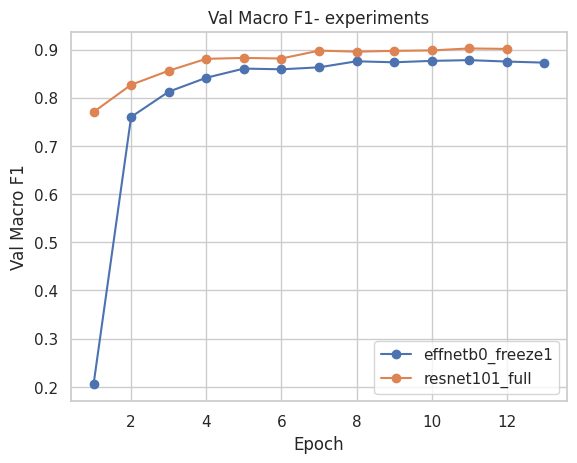

In [ ]:
#Cell 9- Plot results from histories
import seaborn as sns
sns.set(style="whitegrid")
#collect histories
for e in experiments:
    h=e['history']
    epochs=list(range(1, len(h['val_f1'])+1))
    plt.plot(epochs,h['val_f1'],marker='o',label=e['name'])
plt.xlabel("Epoch"); plt.ylabel("Val Macro F1"); plt.title("Val Macro F1- experiments")
plt.legend(); plt.grid(True)
plt.savefig(os.path.join(CFG['save_dir'], "experiments_comparison_val_f1.png"), dpi=150)
plt.show()

In [ ]:
import os, glob
import pandas as pd
SAVE_DIR="/content/food10_experiments"
DRIVE_DIR="/content/drive/MyDrive/food-10/food-10/outputs_experiments"
os.makedirs(SAVE_DIR,exist_ok=True)
ckpts=sorted(glob.glob(os.path.join(DRIVE_DIR,"best_*.pth")))
print("FOUND CHECKPOINTS:",ckpts)
rows=[]
for p in ckpts:
    rows.append({
        "name": os.path.basename(p).replace("best_", "").replace(".pth", ""),
        "best_path": p})

summary=pd.DataFrame(rows)
summary_path=os.path.join(SAVE_DIR, "experiment_summary.csv")
summary.to_csv(summary_path, index=False)
print("Recreated experiment_summary.csv at:",summary_path)
print(summary)

FOUND CHECKPOINTS: ['/content/drive/MyDrive/food-10/food-10/outputs_experiments/best_effnetb0_freeze1.pth', '/content/drive/MyDrive/food-10/food-10/outputs_experiments/best_resnet101_full.pth', '/content/drive/MyDrive/food-10/food-10/outputs_experiments/best_resnet101_resumed.pth']
Recreated experiment_summary.csv at: /content/food10_experiments/experiment_summary.csv
                name                                          best_path
0   effnetb0_freeze1  /content/drive/MyDrive/food-10/food-10/outputs...
1     resnet101_full  /content/drive/MyDrive/food-10/food-10/outputs...
2  resnet101_resumed  /content/drive/MyDrive/food-10/food-10/outputs...


Built test_df with rows: 2500

Evaluating checkpoint: /content/drive/MyDrive/food-10/food-10/outputs_experiments/best_effnetb0_freeze1.pth
Test Macro F1: 0.899788938667679
                         precision    recall  f1-score   support

                cannoli       0.95      0.95      0.95       250
                ceviche       0.90      0.86      0.88       250
             crab_cakes       0.84      0.91      0.87       250
          frozen_yogurt       0.97      0.99      0.98       250
                gnocchi       0.78      0.86      0.82       250
grilled_cheese_sandwich       0.95      0.90      0.92       250
            onion_rings       0.99      0.97      0.98       250
              pork_chop       0.87      0.84      0.85       250
                ravioli       0.80      0.77      0.79       250
    spaghetti_bolognese       0.96      0.96      0.96       250

               accuracy                           0.90      2500
              macro avg       0.90      0.90  

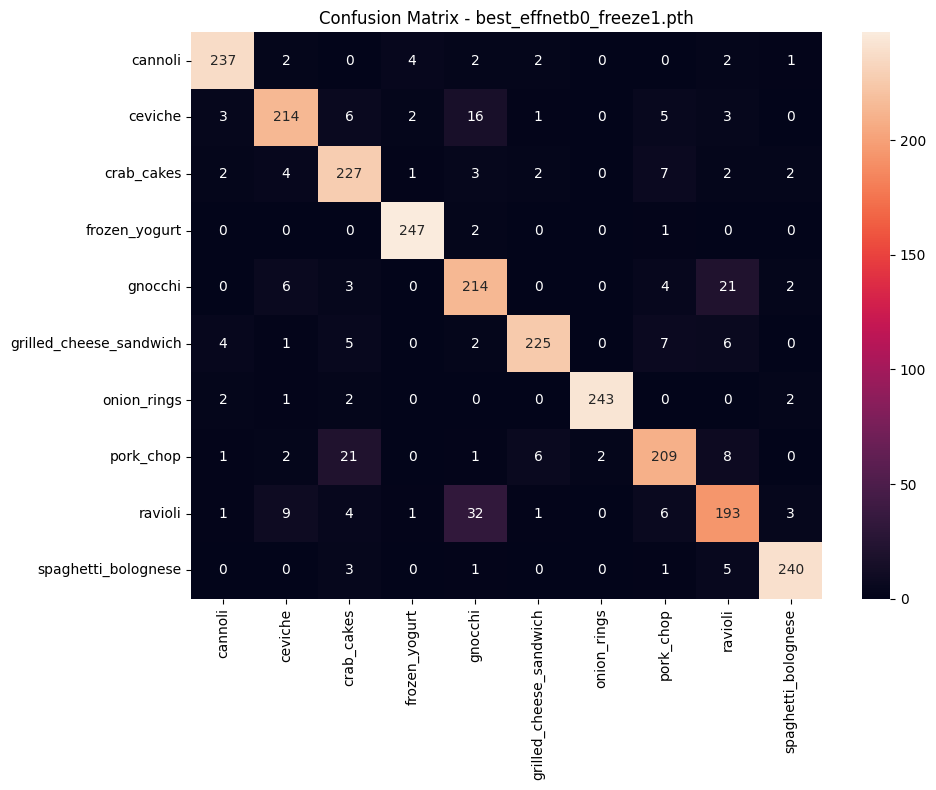


Evaluating checkpoint: /content/drive/MyDrive/food-10/food-10/outputs_experiments/best_resnet101_full.pth
Test Macro F1: 0.9385586718097609
                         precision    recall  f1-score   support

                cannoli       1.00      0.98      0.99       250
                ceviche       0.95      0.88      0.91       250
             crab_cakes       0.87      0.92      0.90       250
          frozen_yogurt       0.99      0.99      0.99       250
                gnocchi       0.87      0.90      0.88       250
grilled_cheese_sandwich       0.94      0.96      0.95       250
            onion_rings       1.00      0.99      0.99       250
              pork_chop       0.92      0.91      0.92       250
                ravioli       0.87      0.89      0.88       250
    spaghetti_bolognese       0.98      0.97      0.97       250

               accuracy                           0.94      2500
              macro avg       0.94      0.94      0.94      2500
           w

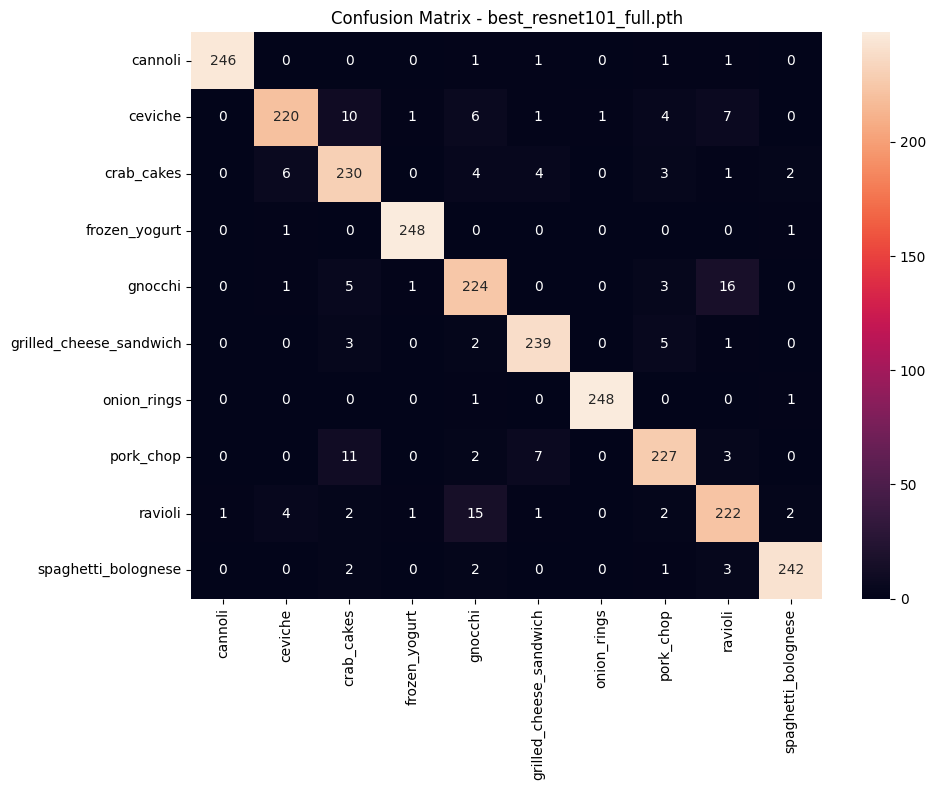


Evaluating checkpoint: /content/drive/MyDrive/food-10/food-10/outputs_experiments/best_resnet101_resumed.pth
Test Macro F1: 0.9308384094072071
                         precision    recall  f1-score   support

                cannoli       0.98      0.97      0.97       250
                ceviche       0.94      0.89      0.92       250
             crab_cakes       0.91      0.90      0.90       250
          frozen_yogurt       0.99      0.99      0.99       250
                gnocchi       0.84      0.87      0.85       250
grilled_cheese_sandwich       0.94      0.96      0.95       250
            onion_rings       1.00      0.98      0.99       250
              pork_chop       0.91      0.93      0.92       250
                ravioli       0.85      0.84      0.84       250
    spaghetti_bolognese       0.96      0.98      0.97       250

               accuracy                           0.93      2500
              macro avg       0.93      0.93      0.93      2500
         

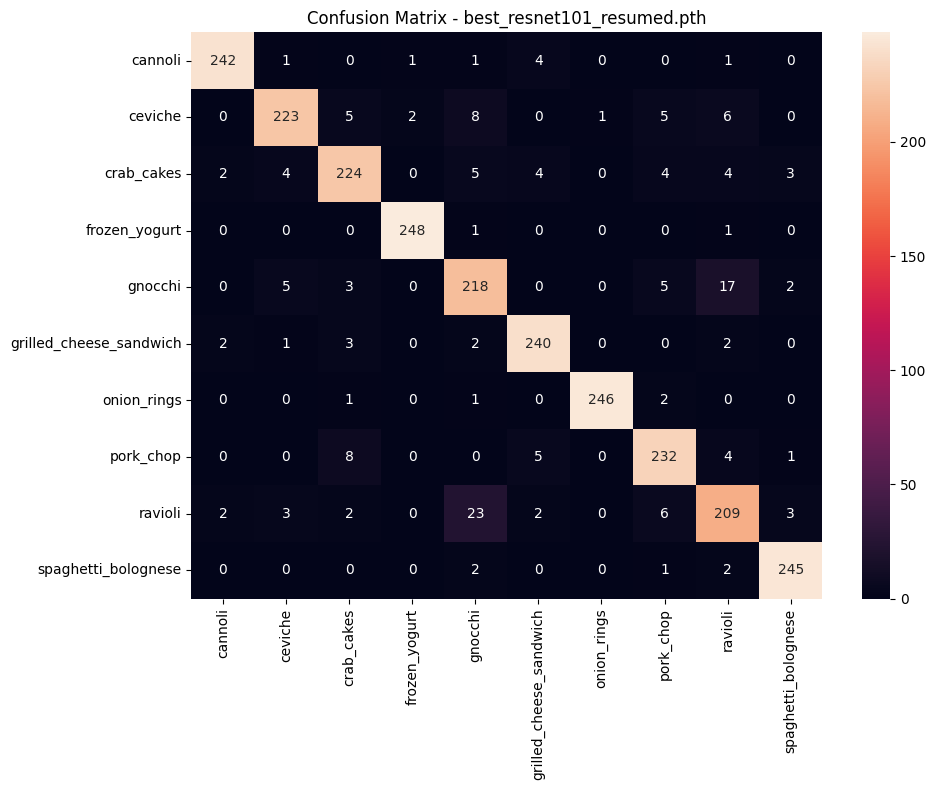

Saved reconstructed_experiment_summary.csv to /content/drive/MyDrive/food-10/food-10/outputs_experiments/reconstructed_experiment_summary.csv


In [ ]:
#Evaluation for timm checkpoints (replacement Cell 10)
import os, glob, json, shutil
import torch
import timm
from PIL import Image
from torchvision import transforms as tvt
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt, seaborn as sns

DEVICE=torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE=CFG.get("img_size",224)
BATCH=64
OUT_DRIVE=os.path.join(ROOT,"outputs_experiments")
LOCAL_OUT="/content/food10_eval"
os.makedirs(LOCAL_OUT,exist_ok=True)

#helpers
def infer_model_name_from_filename(pth):
    name=os.path.basename(pth).lower()
    if "effnet" in name or "efficient" in name: return "efficientnet_b0"
    if "resnet101" in name or "resnet_101" in name: return "resnet101"
    if "resnet50" in name or "resnet_50" in name: return "resnet50"
    if "vit" in name: return "vit_base_patch16_224"
    return None

def infer_num_classes_from_state(ms):
    for k,v in ms.items():
        if hasattr(v,"ndim") and v.ndim==2:
            return int(v.shape[0])
    return None

val_tf=tvt.Compose([
    tvt.Resize(int(IMG_SIZE*1.15)),
    tvt.CenterCrop(IMG_SIZE),
    tvt.ToTensor(),
    tvt.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])])

#making sure test_df and df_all exist and in case that they don't, we re-build them.
def build_test_df_once():
    rows=[]
    IMAGES_DIR=os.path.join(ROOT,"images")
    for cls in sorted(os.listdir(IMAGES_DIR)):
        cls_dir=os.path.join(IMAGES_DIR,cls)
        if not os.path.isdir(cls_dir): continue
        for fname in os.listdir(cls_dir):
            if fname.lower().endswith(('.jpg','.jpeg','.png')):
                rows.append({"path": f"{cls}/{fname}","class": cls,"fullpath": os.path.join(cls_dir,fname)})
    df_all_local=pd.DataFrame(rows)
    df_all_local['no_ext']=df_all_local['class']+"/"+df_all_local['path'].apply(lambda x: os.path.splitext(os.path.basename(x))[0])
    #robust matching test.txt
    with open(os.path.join(ROOT,"test.txt"),'r') as f:
        test_lines=[l.strip() for l in f if l.strip()]
    matched=[]; missing=[]
    for e in test_lines:
        if e in df_all_local['path'].values:
            matched.append(df_all_local[df_all_local['path']==e].iloc[0])
        elif e in df_all_local['no_ext'].values:
            matched.append(df_all_local[df_all_local['no_ext']==e].iloc[0])
        else:
            base=os.path.basename(e).split('.')[0]
            cand=df_all_local[df_all_local['path'].str.contains(base)]
            if len(cand)==1: matched.append(cand.iloc[0])
            else: missing.append(e)
    if missing:
        print("Warning: unmatched test entries (sample):",missing[:10])
    return pd.DataFrame(matched).reset_index(drop=True), df_all_local

#rebuild test_df, df_all if needed
try:
    test_df
    df_all    #Checking for name error and thus implementing error handling by creating test_df and df_all incase they are deleted when runtime got disconnected
except NameError:
    test_df, df_all=build_test_df_once()
    print("Built test_df with rows:",len(test_df))

#loading label mapping from prepared_splits/train.csv
train_csv_path=os.path.join(CSV_DIR,"train.csv")
train_map=pd.read_csv(train_csv_path)
if 'label' not in train_map.columns:
    raise RuntimeError("train.csv is missing 'label' column- run Notebook 01 fix.")
cls2idx=dict(zip(train_map['class'],train_map['label']))
idx2class=[None]*(max(cls2idx.values())+1)
for k,v in cls2idx.items(): idx2class[int(v)]=k

#Reading the experiment summary (that was recreated earlier)
exp_summary=pd.read_csv(os.path.join(CFG["save_dir"],"experiment_summary.csv"))
results=[]
for row in exp_summary.to_dict('records'):
    pth=row['best_path']
    if not os.path.exists(pth):
        print("Checkpoint not found on Drive (skipping):",pth)
        continue
    print("\nEvaluating checkpoint:",pth)
    ckpt=torch.load(pth,map_location='cpu')
    ms=ckpt.get('model_state',ckpt) if isinstance(ckpt,dict) else ckpt
    num_classes_ckpt=infer_num_classes_from_state(ms)
    if num_classes_ckpt is None:
        print("Could not infer num_classes; skipping",pth); continue

    model_name=None
    if isinstance(ckpt,dict) and 'cfg' in ckpt and isinstance(ckpt['cfg'],dict):
        model_name=ckpt['cfg'].get('model_name',None)
    if model_name is None:
        model_name=infer_model_name_from_filename(pth)
    if model_name is None:
        print("Could not infer model name for",pth,"- skipping.")
        continue

    #creating a model and trying to load the state dict
    try:
        model=timm.create_model(model_name,pretrained=False,num_classes=num_classes_ckpt)
    except Exception as e:
        print("timm.create_model failed for", model_name,":", e); continue

    state=ckpt.get('model_state',None) if isinstance(ckpt,dict) else ckpt
    try:
        model.load_state_dict(state)
    except Exception as e:
        try:
            model.load_state_dict(state,strict=False)
            print("Loaded with strict=False (warnings may exist).")
        except Exception as e2:
            print("Failed to load state_dict for",pth,"error:",e2); continue
    model.to(DEVICE).eval()

    #running the inference
    all_preds=[]; all_trues=[]
    for i in range(0,len(test_df),BATCH):
        batch_df=test_df.iloc[i:i+BATCH]
        imgs=[val_tf(Image.open(fp).convert('RGB')) for fp in batch_df['fullpath'].tolist()]
        x=torch.stack(imgs).to(DEVICE)
        with torch.no_grad():
            out=model(x)
            preds=out.argmax(dim=1).cpu().numpy().tolist()
        all_preds.extend(preds)
        all_trues.extend([int(cls2idx[c]) for c in batch_df['class'].tolist()])

    test_f1=f1_score(all_trues,all_preds,average='macro')
    print("Test Macro F1:",test_f1)
    try:
        print(classification_report(all_trues,all_preds,target_names=idx2class))
    except Exception as e:
        print("classification_report failed:",e)

    cm=confusion_matrix(all_trues,all_preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm,annot=True,fmt='d',xticklabels=idx2class,yticklabels=idx2class)
    plt.title(f"Confusion Matrix - {os.path.basename(pth)}")
    savepath=os.path.join(LOCAL_OUT,os.path.basename(pth).replace('.pth','_confmat.png'))
    plt.tight_layout(); plt.savefig(savepath,dpi=150); plt.show()
    shutil.copy(savepath,os.path.join(OUT_DRIVE,os.path.basename(savepath)))
    results.append({"pth": pth,"model": model_name,"test_f1": float(test_f1),"confmat": savepath})

#saving reconstructed summary back to the drive
if results:
    pd.DataFrame(results).to_csv(os.path.join(OUT_DRIVE, "reconstructed_experiment_summary.csv"), index=False)
    print("Saved reconstructed_experiment_summary.csv to", os.path.join(OUT_DRIVE, "reconstructed_experiment_summary.csv"))
else:
    print("No results to save.")

In [ ]:
import pandas as pd
import os
#Paths
SAVE_DIR=CFG["save_dir"]
#Building a clean summary table
clean_exp_df=pd.DataFrame([
    {
        "name": "effnetb0_freeze1",
        "best_val_f1": None,   #This is optional and only to achieve a clean result by removing the resumed pth file's data that's no longer needed
        "best_path": os.path.join(SAVE_DIR, "best_effnetb0_freeze1.pth")},
    {
        "name": "resnet101_full",
        "best_val_f1": None,
        "best_path": os.path.join(SAVE_DIR, "best_resnet101_full.pth")}])
#Save
clean_exp_df.to_csv(os.path.join(SAVE_DIR,"experiment_summary.csv"),index=False)
print("Rewritten experiment_summary.csv:")
print(clean_exp_df)

Rewritten experiment_summary.csv:
               name best_val_f1  \
0  effnetb0_freeze1        None   
1    resnet101_full        None   

                                           best_path  
0  /content/food10_experiments/best_effnetb0_free...  
1  /content/food10_experiments/best_resnet101_ful...  
